In [1]:
# Importing the necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import gc
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\yskk9\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Defining constants
batch_size = 16 # Batch size was changed from 32 to 16, as the training would stop or freeze after first epoch training
epochs = 10
class_number = 2  # Public_Buildings and Appartments

In [3]:
# Defining the VGG16 model with weights pre-trained on ImageNet
model_vg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [4]:
# Freezing the convolutional layers to prevent them from being updated during training
for layer in model_vg.layers:
    layer.trainable = False

In [5]:
# Creating a new model on top of the pre-trained model
model = models.Sequential([
    model_vg,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(class_number, activation='softmax')
])

In [6]:
# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
# Iterating through the directory structure to gather image paths and corresponding labels
data_location = 'C:/Users/yskk9/Desktop/Modern Architecture'

data_images = []
data_labels = []

for category in os.listdir(data_location):
    category_path = os.path.join(data_location, category)
    if os.path.isdir(category_path):
        for image in os.listdir(category_path):
            image_path = os.path.join(category_path, image)
            data_images.append(image_path)
            data_labels.append(category)

In [8]:
# Creating a Pandas DataFrame with two columns: 'Image_Path' and 'Label' , and the data for these columns is provided 
# in the data_images and data_labels variables, respectively
df = pd.DataFrame({'Image_Path': data_images, 'Label': data_labels})

In [23]:
print(df['Label'].value_counts())

Appartments           82920
Public_Buildings      18919
.ipynb_checkpoints        3
Name: Label, dtype: int64


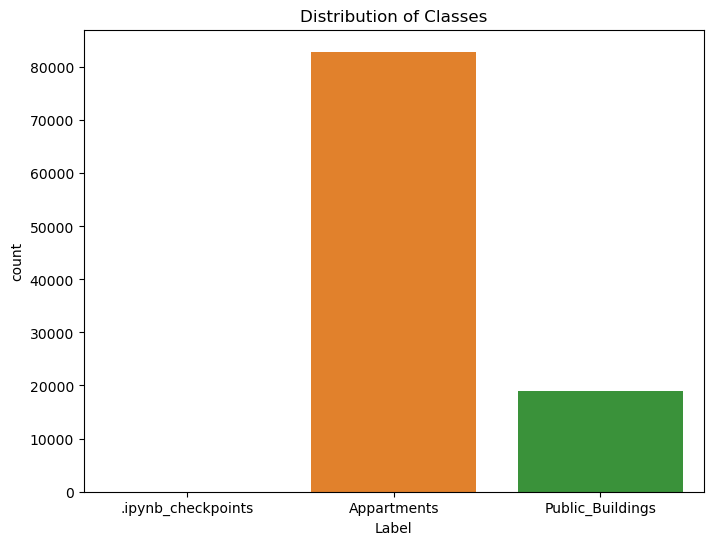

In [24]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Label', data=df)
plt.title('Distribution of Classes')
plt.show()

In [25]:
class_percentage = df['Label'].value_counts(normalize=True) * 100
print(class_percentage)

Appartments           81.420239
Public_Buildings      18.576815
.ipynb_checkpoints     0.002946
Name: Label, dtype: float64


In [9]:
# Printing unique values in the 'Label' column of the Pandas DataFrame df
print("Unique Labels:", df['Label'].unique())

Unique Labels: ['.ipynb_checkpoints' 'Appartments' 'Public_Buildings']


In [10]:
# Create a binary DataFrame (df_binary) that includes only the rows where the 'Label' column is either 
# "Apartments" or "Public_Buildings"
df_binary = df.query('Label == "Appartments" or Label == "Public_Buildings"')

In [11]:
# Print unique values in the 'Label' column of the DataFrame df_binary
print("Unique Labels in df_binary:", df_binary['Label'].unique())

Unique Labels in df_binary: ['Appartments' 'Public_Buildings']


In [12]:
# Calculating the minimum count of occurrences for each unique label in the 'Label' column of the DataFrame df_binary
min_count = min(df_binary['Label'].value_counts())

In [13]:
# Downsampling the DataFrame df_binary by randomly sampling a specified minimum count of instances for each label 
# ('Appartments' and 'Public_Buildings') using the sample method 
# After downsampling, concatenating the sampled DataFrames into a new DataFrame called df_model
df_model = pd.concat([
    df_binary[df_binary['Label'] == 'Appartments'].sample(min_count, replace=True),
    df_binary[df_binary['Label'] == 'Public_Buildings'].sample(min_count, replace=True)
])

del df_binary
gc.collect()

print(f'After downsampling, there are {df_model.shape[0]} images classified as either Appartments ({sum(df_model["Label"] == "Appartments")}) or Public_Buildings ({sum(df_model["Label"] == "Public_Buildings")})')

After downsampling, there are 37838 images classified as either Appartments (18919) or Public_Buildings (18919)


In [14]:
# Further downsampling the already downsampled dataset
# Decrease for lower epoch training time
subset_size = 1000  # Adjust the size accordingly

df_model_subset = pd.concat([
    df_model[df_model['Label'] == 'Appartments'].sample(subset_size, replace=True),
    df_model[df_model['Label'] == 'Public_Buildings'].sample(subset_size, replace=True)
])

print(f'After further downsampling, there are {df_model_subset.shape[0]} images classified as either Appartments ({sum(df_model_subset["Label"] == "Appartments")}) or Public_Buildings ({sum(df_model_subset["Label"] == "Public_Buildings")})')

After further downsampling, there are 2000 images classified as either Appartments (1000) or Public_Buildings (1000)


In [15]:
# Assuming df_model is the downsampled DataFrame
#train_df, test_df = train_test_split(df_model, test_size=0.2, random_state=42)

In [16]:
# Assuming df_model_subset is the further downsampled DataFrame
train_df_subset, test_df_subset = train_test_split(df_model_subset, test_size=0.2, random_state=42)

In [17]:
# Data augmentation for training images
datag_train = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
# Rescaling for test images
datag_test = ImageDataGenerator(rescale=1./255)

#train_generator = datag_train.flow_from_dataframe(
#    train_df,
#    x_col='Image_Path',
#    y_col='Label',
#    target_size=(224, 224),
#    batch_size=batch_size,
#    class_mode='categorical',  
#    shuffle=True
#)
#
#test_generator = datag_test.flow_from_dataframe(
#    test_df,
#    x_col='Image_Path',
#    y_col='Label',
#    target_size=(224, 224),
#    batch_size=batch_size,
#    class_mode='categorical', 
#    shuffle=False  # Set shuffle to False for the test set
#)
# Create image data generators for training and testing using the further downsampled data
# For the training data subset
train_generator_subset = datag_train.flow_from_dataframe(
    train_df_subset,
    x_col='Image_Path',
    y_col='Label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical', # or 'binary', depending on the problem
    shuffle=True # Shuffling the data during training
)
# For the test data subset
test_generator_subset = datag_test.flow_from_dataframe(
    test_df_subset,
    x_col='Image_Path',
    y_col='Label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',  # or 'binary', depending on the problem
    shuffle=False  # No need to shuffle the data during evaluation
)

Found 1600 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.


In [18]:
# Training the model
#history = model.fit(
#    train_generator,
#    steps_per_epoch=train_generator.samples // batch_size,
#    epochs=epochs,
#    validation_data=test_generator,
#    validation_steps=test_generator.samples // batch_size
#)

In [19]:
# Training the model with the further downsampled data
history_subset = model.fit(
    train_generator_subset,
    steps_per_epoch=train_generator_subset.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator_subset,
    validation_steps=test_generator_subset.samples // batch_size
)

Epoch 1/10
100/100 [==============================] - 260s 3s/step - loss: 0.7479 - accuracy: 0.5644 - val_loss: 0.6442 - val_accuracy: 0.6375
Epoch 2/10
100/100 [==============================] - 276s 3s/step - loss: 0.6400 - accuracy: 0.6363 - val_loss: 0.6379 - val_accuracy: 0.6325
Epoch 3/10
100/100 [==============================] - 273s 3s/step - loss: 0.6165 - accuracy: 0.6544 - val_loss: 0.6303 - val_accuracy: 0.6600
Epoch 4/10
100/100 [==============================] - 257s 3s/step - loss: 0.5950 - accuracy: 0.6900 - val_loss: 0.6173 - val_accuracy: 0.6775
Epoch 5/10
100/100 [==============================] - 256s 3s/step - loss: 0.5737 - accuracy: 0.7000 - val_loss: 0.6296 - val_accuracy: 0.6400
Epoch 6/10
100/100 [==============================] - 254s 3s/step - loss: 0.5647 - accuracy: 0.7000 - val_loss: 0.6181 - val_accuracy: 0.6975
Epoch 7/10
100/100 [==============================] - 255s 3s/step - loss: 0.5414 - accuracy: 0.7231 - val_loss: 0.6188 - val_accuracy: 0.6650

In [20]:
# Saving the model after training in the native Keras format
model.save('final_model.keras')

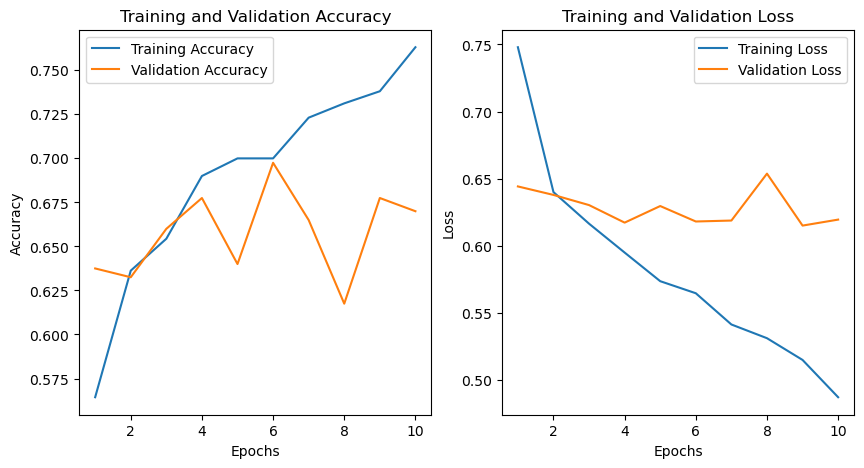

Final Training Accuracy: 0.7631250023841858
Final Validation Accuracy: 0.6700000166893005
Final Training Loss: 0.48722636699676514
Final Validation Loss: 0.6195381879806519


In [21]:
# Accessing accuracy and loss values from the training history
train_accuracy = history_subset.history['accuracy']
val_accuracy = history_subset.history['val_accuracy']
train_loss = history_subset.history['loss']
val_loss = history_subset.history['val_loss']

epochs_range = range(1, epochs + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

# Printing final training and validation accuracy, loss
print("Final Training Accuracy:", train_accuracy[-1])
print("Final Validation Accuracy:", val_accuracy[-1])
print("Final Training Loss:", train_loss[-1])
print("Final Validation Loss:", val_loss[-1])

25/25 [==============================] - 54s 2s/step


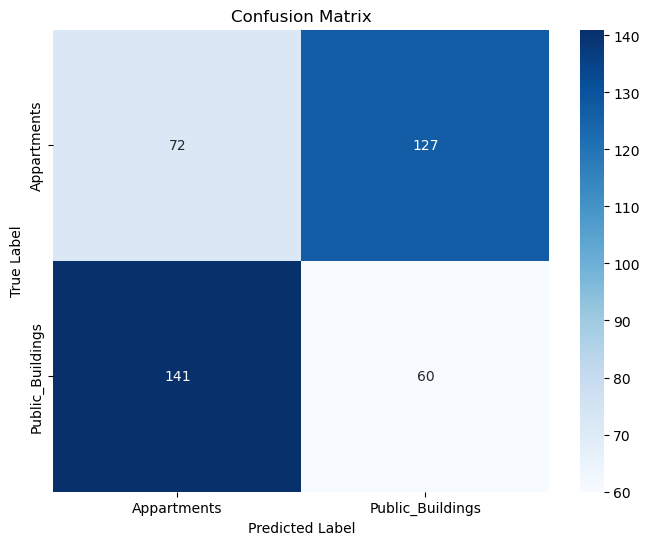

                  precision    recall  f1-score   support

     Appartments       0.34      0.36      0.35       199
Public_Buildings       0.32      0.30      0.31       201

        accuracy                           0.33       400
       macro avg       0.33      0.33      0.33       400
    weighted avg       0.33      0.33      0.33       400



In [22]:
# Generating predictions on the test set
predictions = model.predict(test_generator_subset)

# Converting predictions to class labels
predicted_labels = [1 if pred[0] > 0.5 else 0 for pred in predictions]

# Converting true labels to binary
true_labels = test_generator_subset.labels

# Computing confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Displaying the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Appartments', 'Public_Buildings'], yticklabels=['Appartments', 'Public_Buildings'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print(classification_report(true_labels, predicted_labels, target_names=['Appartments', 'Public_Buildings']))